## Data Preparation

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

In [2]:
# The topic of interest.
topic_dir = "/hourly/precipitation/historical/"
#topic_dir = "/annual/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

In [3]:
local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallelly merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin


In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD//hourly/precipitation/historical/
../data/original/DWD//hourly/precipitation/historical/

../data/generated/DWD/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/


In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
#Importing the required packages
import os
import ftplib
import pandas as pd
import codecs
import seaborn as sns
from datetime import datetime
from zipfile import ZipFile
from matplotlib import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
#from adjustText import adjust_text
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors

In [8]:
#generate data frame from ftp directories/files
def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:
        # issue the command LIST in the FTP connection 
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_hourly_precipi...,.pdf,166317,-
1,-1,DESCRIPTION_obsgermany_climate_hourly_precipit...,.pdf,161348,-
2,-1,RR_Stundenwerte_Beschreibung_Stationen.txt,.txt,303009,-
3,3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
4,20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
5,44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
6,53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
7,71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
8,73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
9,78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-


In [9]:
#get the list of station ids and corresponding zip file
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-
87,stundenwerte_RR_00087_20050201_20201231_hist.zip,.zip,403610,-
91,stundenwerte_RR_00091_20040901_20201231_hist.zip,.zip,419182,-


In [10]:
#read the files in ftp
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to check the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")
        
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print("grab file: " + station_fname + "\nfrom ftp dir: " + ftp_dir)
grabFile(ftp_dir + station_fname, local_station_dir + station_fname)

grab file: RR_Stundenwerte_Beschreibung_Stationen.txt
from ftp dir: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/


In [11]:
#convert station description text file to csv file and change the column names.
def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    # German-English dictionary
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    txtfile.encode('unicode_escape').strip()
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0,encoding='unicode_escape')
    
    # write CSV file with field separator semicolon
    df.to_csv(csvfile, sep = ";")
    return(df)

basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2022-03-12,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
29,2006-01-10,2022-03-12,260,49.7175,10.9101,Adelsdorf (Kläranlage),Bayern
44,2007-04-01,2022-03-12,44,52.9336,8.2370,Großenkneten,Niedersachsen
46,2006-01-03,2022-03-12,325,48.9450,12.4639,Aholfing,Bayern


In [12]:
# select only counties in North Rhine-Westfalen
isNRW = df_stations['state'].str.contains("Nordrhein")

dfNRW = df_stations[isNRW]

#print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
216,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
326,2004-07-01,2013-07-08,120,51.7204,8.0577,Beckum-Unterberg,Nordrhein-Westfalen
389,2009-11-01,2022-03-12,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
390,2004-07-01,2022-03-12,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
...,...,...,...,...,...,...,...
14184,2016-06-01,2022-03-12,126,51.2242,7.1070,Wuppertal-Buchenhofen/Wupper,Nordrhein-Westfalen
14185,2017-08-01,2022-03-12,304,51.6050,8.8175,Lichtenau-Ebbinghausen (HRB),Nordrhein-Westfalen
14186,2017-08-01,2022-03-12,291,51.5319,8.7289,Gollentaler Grund (HRB),Nordrhein-Westfalen


In [13]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00003_19950901_20110401_hist.zip
stundenwerte_RR_00216_20041001_20201231_hist.zip
stundenwerte_RR_00326_20040701_20130708_hist.zip
stundenwerte_RR_00389_20091101_20201231_hist.zip
stundenwerte_RR_00390_20040701_20201231_hist.zip
stundenwerte_RR_00554_19950901_20201231_hist.zip
stundenwerte_RR_00555_20080101_20181101_hist.zip
stundenwerte_RR_00599_19950901_19990302_hist.zip
stundenwerte_RR_00603_19990303_20201231_hist.zip
stundenwerte_RR_00613_20041101_20201231_hist.zip
stundenwerte_RR_00617_20040601_20201231_hist.zip
stundenwerte_RR_00644_20050101_20201231_hist.zip
stundenwerte_RR_00796_20041101_20201231_hist.zip
stundenwerte_RR_00871_20050801_20201231_hist.zip
stundenwerte_RR_00902_20061001_20201231_hist.zip
stundenwerte_RR_00934_20041001_20201231_hist.zip
stundenwerte_RR_00989_20050201_20201231_hist.zip
stundenwerte_RR_01024_20060801_20201231_hist.zip
stundenwerte_RR_01046_20041001_20201231_hist.zip
stundenwerte_RR_01078_19950901_20201231_hist.zip
stundenwerte_RR_0124

In [14]:
#generate precipitation time series and store in dataframe
def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_',regex= True).str.replace('(', '',regex= True).str.replace(')', '',regex= True)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [15]:
#merge all the precipitation time series generated into singe dataframe
def prec_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

df_merged_ts = prec_ts_merge()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00003_19950901_20110401_hist.zip
Extract product file: produkt_rr_stunde_19950901_20110401_00003.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00326_20040701_20130708_hist.zip
Extract product file: produkt_rr_stunde_20040701_20130708_00326.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

In [16]:
#glance the contents of the created dataframe
df_merged_ts.head()

,3,216,326,389,390,554,555,599,603,613,...,7344,7374,7378,13669,13670,13671,13696,13700,13713,15000
time,,,,,,,,,,,,,,,,,,,,,
1995-09-01 00:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 01:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 02:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 03:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-01 04:00:00,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#join the precipitation station description data with the time series data
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
# TEMPERATURE                dftmp = temp_ts_to_df(myfile)
# PRECIPIATION
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

df_appended_ts = ts_append()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00003_19950901_20110401_hist.zip
Extract product file: produkt_rr_stunde_19950901_20110401_00003.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00326_20040701_20130708_hist.zip
Extract product file: produkt_rr_stunde_20040701_20130708_00326.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00554_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_00554.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00555_20080101_20181101_hist.zip
Extract product file: produkt_rr_stunde_20080101_20181101_00555.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00599_19950901_19990302_hist.zip
Extract product file: produkt_rr_stunde_19950901_19990302_00599.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00603_19990303_20201231_hist.zip
Extract product file: produkt_rr_stunde_19990303_20201231_00603.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00613_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_00613.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00617_20040601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040601_20201231_00617.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00644_20050101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050101_20201231_00644.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00796_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_00796.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00871_20050801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050801_20201231_00871.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00902_20061001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20061001_20201231_00902.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00934_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00934.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00989_20050201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050201_20201231_00989.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01024_20060801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060801_20201231_01024.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01046_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_01046.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01078_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_01078.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01241_20061201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20061201_20201231_01241.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01246_20150801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20150801_20201231_01246.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01300_20040601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040601_20201231_01300.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01303_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_01303.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01327_20040801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040801_20201231_01327.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01590_20030701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20030701_20201231_01590.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01595_20121001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20121001_20201231_01595.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_01766_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_01766.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02027_20060601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060601_20201231_02027.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02110_20030105_20201231_hist.zip
Extract product file: produkt_rr_stunde_20030105_20201231_02110.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02254_20050601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050601_20201231_02254.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02473_20041201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20201231_02473.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02483_19951012_20201231_hist.zip
Extract product file: produkt_rr_stunde_19951012_20201231_02483.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02497_20040801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040801_20201231_02497.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02629_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_02629.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02667_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_02667.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02703_19950901_20001010_hist.zip
Extract product file: produkt_rr_stunde_19950901_20001010_02703.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02810_20061201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20061201_20201231_02810.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02947_20061001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20061001_20201231_02947.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02968_20081201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20081201_20201231_02968.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_02999_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_02999.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03028_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_03028.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03031_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_03031.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03081_20071201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20071201_20201231_03081.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03098_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_03098.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03215_20070601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20070601_20201231_03215.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03321_20050701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050701_20201231_03321.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03339_20060901_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060901_20201231_03339.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03499_20060701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060701_20201231_03499.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03540_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_03540.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03591_20040601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040601_20201231_03591.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03795_20041201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20201231_03795.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_03913_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_03913.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04063_20030701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20030701_20201231_04063.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04127_20050101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050101_20201231_04127.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04150_20051201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20051201_20201231_04150.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04154_20110201_20180701_hist.zip
Extract product file: produkt_rr_stunde_20110201_20180701_04154.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04313_20040801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040801_20201231_04313.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04368_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_04368.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04371_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_04371.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04400_20040801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040801_20201231_04400.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04488_20060801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060801_20201231_04488.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04692_20080301_20181201_hist.zip
Extract product file: produkt_rr_stunde_20080301_20181201_04692.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04741_20041201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20201231_04741.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_04849_20050601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050601_20201231_04849.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05064_20041201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20201231_05064.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05347_19950901_20201231_hist.zip
Extract product file: produkt_rr_stunde_19950901_20201231_05347.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05360_20070701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20070701_20201231_05360.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05468_20060701_20201001_hist.zip
Extract product file: produkt_rr_stunde_20060701_20201001_05468.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05480_20030910_20201231_hist.zip
Extract product file: produkt_rr_stunde_20030910_20201231_05480.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05513_20050901_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050901_20201231_05513.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05619_20041201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20201231_05619.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05699_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_05699.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05717_20060901_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060901_20201231_05717.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05719_20041001_20091210_hist.zip
Extract product file: produkt_rr_stunde_20041001_20091210_05719.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_05733_20050501_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050501_20201231_05733.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_06197_20001013_20201231_hist.zip
Extract product file: produkt_rr_stunde_20001013_20201231_06197.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_06264_20040601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040601_20201231_06264.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_06276_20041101_20191102_hist.zip
Extract product file: produkt_rr_stunde_20041101_20191102_06276.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_06313_20041201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041201_20201231_06313.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_06337_20040801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040801_20201231_06337.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_07106_20060901_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060901_20201231_07106.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_07330_20051001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20051001_20201231_07330.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_07344_20060601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060601_20201231_07344.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_07374_20060301_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060301_20201231_07374.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_07378_20060701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060701_20201231_07378.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_13669_20070901_20201231_hist.zip
Extract product file: produkt_rr_stunde_20070901_20201231_13669.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_13670_20070601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20070601_20201231_13670.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_13671_20071201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20071201_20201231_13671.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_13696_20071201_20201231_hist.zip
Extract product file: produkt_rr_stunde_20071201_20201231_13696.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_13700_20080501_20201231_hist.zip
Extract product file: produkt_rr_stunde_20080501_20201231_13700.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_13713_20071101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20071101_20201231_13713.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_15000_20110401_20201231_hist.zip
Extract product file: produkt_rr_stunde_20110401_20201231_15000.txt



/var/folders/nv/b5gt_2xs6_b2b50_jwyn74wm0000gn/T/ipykernel_9286/308058508.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


In [18]:
df_appended_ts.head()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
1995-09-01 00:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 01:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 02:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 03:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1995-09-01 04:00:00,3,1,0.0,0.0,NaN,eor,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen


In [19]:
df_appended_ts_roi=df_appended_ts[(df_appended_ts['stations_id']==3098) |
               (df_appended_ts['stations_id']==4127) |
               (df_appended_ts['stations_id']==5619) |
               (df_appended_ts['stations_id']==6313) |
               (df_appended_ts['stations_id']==13713) |
               (df_appended_ts['stations_id']==14183) |
               (df_appended_ts['stations_id']==613) |
               (df_appended_ts['stations_id']==644) |
               (df_appended_ts['stations_id']==934) |
               (df_appended_ts['stations_id']==3028) |
               (df_appended_ts['stations_id']==4313) |
               (df_appended_ts['stations_id']==4368) |
               (df_appended_ts['stations_id']==5699) |
               (df_appended_ts['stations_id']==14185) |
               (df_appended_ts['stations_id']==14186) | 
               (df_appended_ts['stations_id']==14187) |
               (df_appended_ts['stations_id']==14145) |
               (df_appended_ts['stations_id']==14172) |
               (df_appended_ts['stations_id']==14173) |
               (df_appended_ts['stations_id']==13700) | 
               (df_appended_ts['stations_id']==14182) |
               (df_appended_ts['stations_id']==216) | 
               (df_appended_ts['stations_id']==1300) |
               (df_appended_ts['stations_id']==2483) |
               (df_appended_ts['stations_id']==2947) | 
               (df_appended_ts['stations_id']==3215) |
               (df_appended_ts['stations_id']==4400) |
               (df_appended_ts['stations_id']==4488) |
               (df_appended_ts['stations_id']==5360) |
               (df_appended_ts['stations_id']==6264) |
               (df_appended_ts['stations_id']==7330) |
               (df_appended_ts['stations_id']==14170) |
               (df_appended_ts['stations_id']==14171) |
               (df_appended_ts['stations_id']==3499) |
               (df_appended_ts['stations_id']==5468) | 
               (df_appended_ts['stations_id']==389) | 
               (df_appended_ts['stations_id']==390) |
               (df_appended_ts['stations_id']==796) |
               (df_appended_ts['stations_id']==4692) |
               (df_appended_ts['stations_id']==3031) |
               (df_appended_ts['stations_id']==5480) |
               (df_appended_ts['stations_id']==6276) |
               (df_appended_ts['stations_id']==14143) |                                        
               (df_appended_ts['stations_id']==5347)]
df_appended_ts_roi

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2004-10-01 00:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 01:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 02:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 03:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 04:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,13713,3,0.0,1.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 21:00:00,13713,3,0.1,1.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [20]:
#the date of interest is selected 2018-04-16 to 2018-08-16
idx=(df_appended_ts_roi.index >= '2018-04-16 00:00:00') & (df_appended_ts_roi.index<'2018-08-16 00:00:00')

In [35]:
df_appended_ts_countiesofinterest=df_appended_ts_roi[idx]
df_appended_ts_countiesofinterest.tail()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2018-08-15 19:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 21:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 22:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2018-08-15 23:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [36]:
df_appended_ts_countiesofinterest.head(100)
#df_appended_ts_countiesofinterest.reset_index(level=0, inplace=True)
df_appended_ts_countiesofinterest.to_csv(r"13_counties_stations_4_months_data.csv")

In [37]:
import pandas as pd 
import numpy as np
import time
import datetime

In [38]:
data_frame = pd.read_csv('13_counties_stations_4_months_data.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_frame

,mess_datum,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
0,2018-04-16 00:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,2018-04-16 01:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2,2018-04-16 02:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
3,2018-04-16 03:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
4,2018-04-16 04:00:00,216,3,0.0,0.0,NaN,eor,2004-10-01,2022-03-12,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96195,2018-08-15 19:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
96196,2018-08-15 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
96197,2018-08-15 21:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
96198,2018-08-15 22:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-12,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [39]:
df = data_frame.groupby(['stations_id', 'altitude', 'latitude', 'longitude', 'name', 'state'])['r1'].sum()

In [40]:
df = pd.DataFrame(df)
df

,,,,,,r1
stations_id,altitude,latitude,longitude,name,state,
216,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen,273.7
389,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen,175.6
390,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen,179.2
613,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen,130.1
644,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen,115.0
796,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen,168.0
934,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen,116.8
1300,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen,201.8
2483,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen,222.2


In [47]:
#df.reset_index(level=0, inplace=True)
columns_titles = ["stations_id","r1","altitude","latitude","longitude","name","state" ]
df=df.reindex(columns=columns_titles)
df

,stations_id,r1,altitude,latitude,longitude,name,state
0,216,273.7,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,389,175.6,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
2,390,179.2,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
3,613,130.1,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen
4,644,115.0,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen
5,796,168.0,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen
6,934,116.8,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen
7,1300,201.8,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
8,2483,222.2,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
9,2947,291.1,286,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen


In [48]:
df.rename(columns={'r1': 'prec_value'}, inplace=True)
df

,stations_id,prec_value,altitude,latitude,longitude,name,state
0,216,273.7,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,389,175.6,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
2,390,179.2,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
3,613,130.1,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen
4,644,115.0,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen
5,796,168.0,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen
6,934,116.8,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen
7,1300,201.8,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
8,2483,222.2,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
9,2947,291.1,286,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen


In [49]:
df.to_csv(r'Data_for_visualizaion_5.csv', index = False)

## Data Visualization

### Total Precipitation vs Altitude

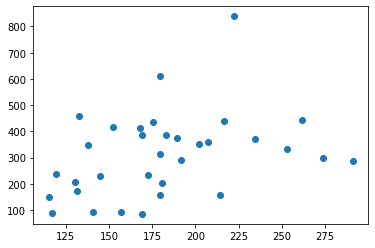

In [50]:
#df[['prec_value', 'altitude']].plot()
x= df['prec_value']
y= df['altitude']
plt.plot(x, y, 'o')

In [51]:
from adjustText import adjust_text
val= df['prec_value']
altitude= df['altitude']
station=df['stations_id']

In [52]:
#!pip install adjustText
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(val, altitude)
print(slope, intercept, r_value, p_value, std_err)
r_value_square = r_value * r_value
print(r_value_square)

1.2311568276681852 87.16784671405864 0.35258503601421043 0.04416718203612157 0.5868705415004954
0.12431620762114207


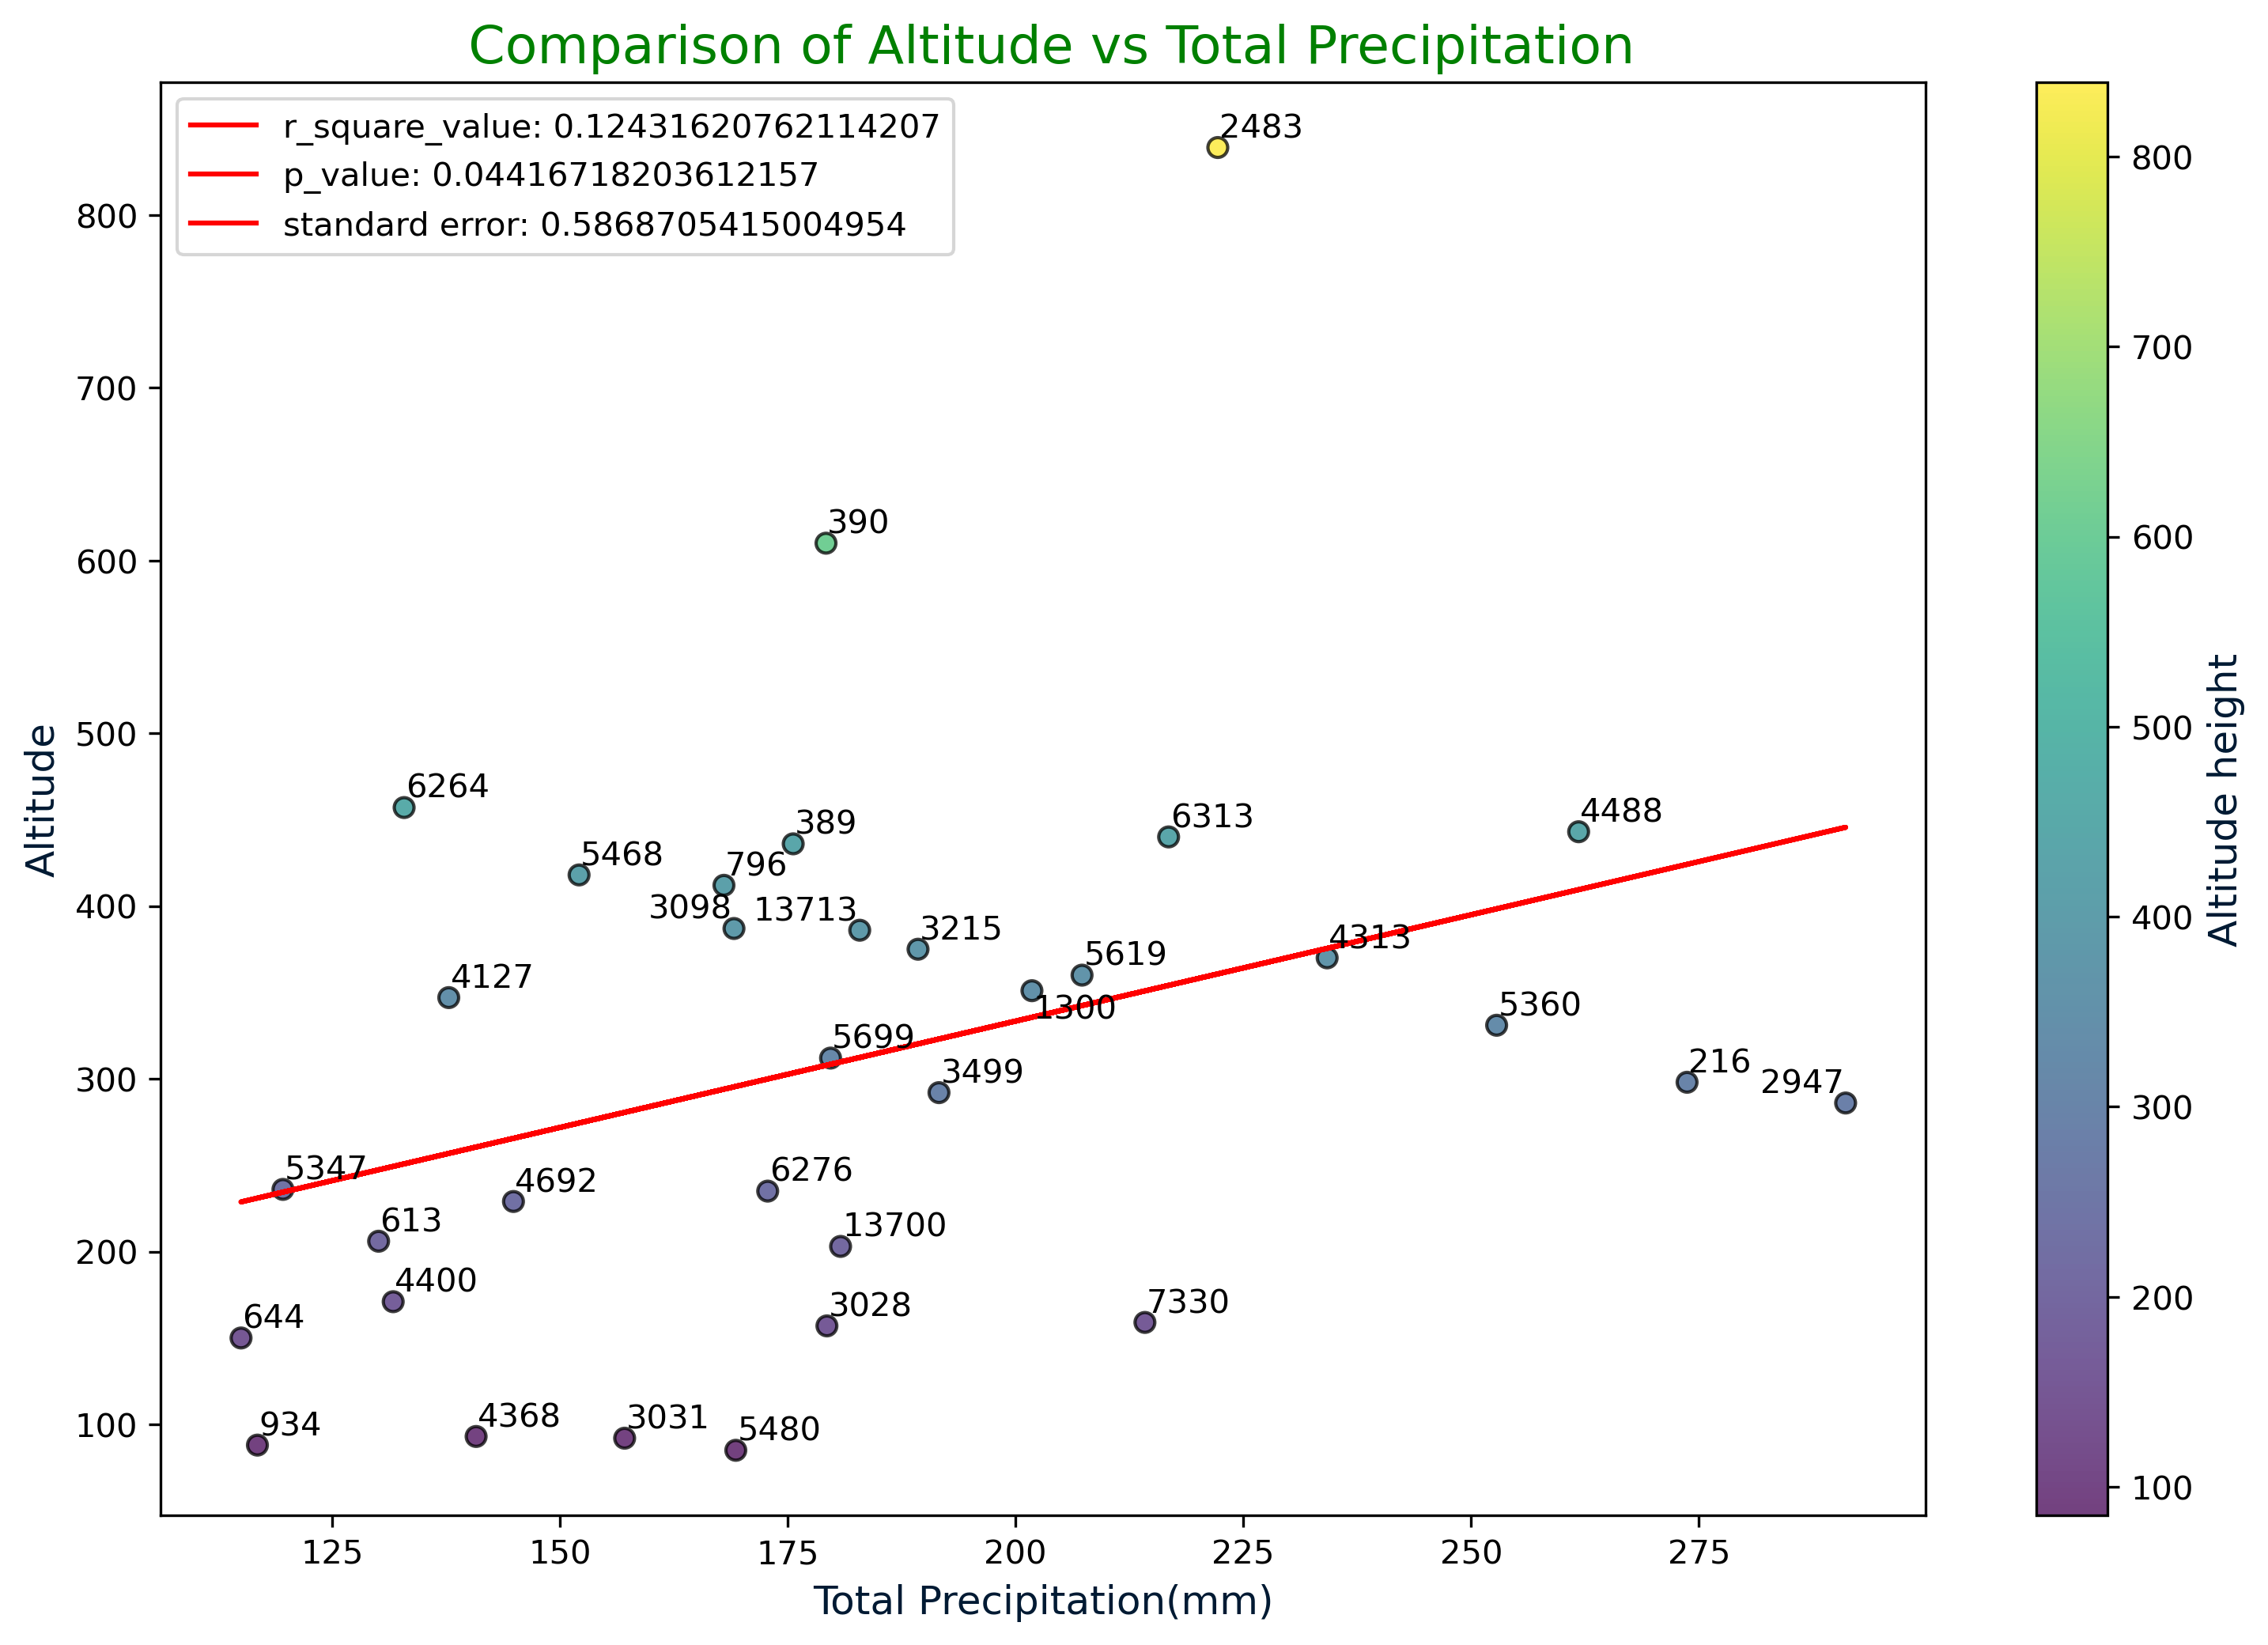

In [88]:
fig = plt.figure(dpi = 300, figsize = (12, 8), clear = True)
plt.xlabel("Total Precipitation(mm)",fontdict={'fontname' : 'Sans-Serif', 'fontsize': 12}, color= '#001a33')
plt.ylabel("Altitude",fontdict={'fontname' : 'Sans-Serif', 'fontsize': 12}, color= '#001a33')
plt.scatter(val, altitude, c = altitude, cmap = 'viridis',  edgecolor = 'black', linewidth = 1, alpha = 0.75)
cbar = plt.colorbar()
cbar.set_label("Altitude height",fontdict={'fontname' : 'Sans-Serif', 'fontsize': 12}, color= '#001a33')
#linear regression
m, b = np.polyfit(val, altitude, 1)
plt.plot(val, m*val+b,color='#ff0000', label = "r_square_value: "+str(r_value_square))
plt.plot(val, m*val+b, color='#ff0000', label = "p_value: "+str(p_value))
plt.plot(val, m*val+b, color='#ff0000', label = "standard error: "+str(std_err))


#for i, txt in enumerate(station):
    #plt.annotate(txt, (val[i], altitude[i]), size=9)
    
texts = [plt.text(val[i], altitude[i], '%s' %txt) for  i, txt in enumerate(station) ]
adjust_text(texts)

plt.title(" Comparison of Altitude vs Total Precipitation",fontdict={'fontname' : 'Sans-Serif', 'fontsize': 16},color = 'green')

plt.legend(loc="upper left")

fig.savefig('Altitude_vs_Prec.jpeg')
plt.show()

### Altitude vs DTM Altitude

In [76]:
dtm_data_frame = pd.read_csv('dtm_altitude_data.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

In [80]:
#dtm_data_frame.reset_index(level=0, inplace=True)
dtm_data_frame

,stations_id,prec_value,altitude,latitude,longitude,name,state,SAMPLE_1
0,216,273.7,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen,298.100006
1,389,175.6,436,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen,433.500000
2,390,179.2,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen,612.200012
3,613,130.1,206,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen,205.000000
4,644,115.0,150,51.7049,9.1738,Brakel,Nordrhein-Westfalen,150.199997
5,796,168.0,412,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen,413.399994
6,934,116.8,88,51.7835,8.5658,Delbrück,Nordrhein-Westfalen,87.700005
7,1300,201.8,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen,354.800018
8,2483,222.2,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen,838.500000
9,2947,291.1,286,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen,287.000000


In [81]:
columns_titles = ["stations_id","prec_value","altitude","SAMPLE_1" ,"latitude","longitude","name","state"]

dtm_data_frame=dtm_data_frame.reindex(columns=columns_titles)

In [82]:
dtm_data_frame.rename(columns={'SAMPLE_1': 'dtm_altitude'}, inplace=True)

In [83]:
dtm_data_frame

,stations_id,prec_value,altitude,dtm_altitude,latitude,longitude,name,state
0,216,273.7,298,298.100006,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
1,389,175.6,436,433.500000,51.0148,8.4318,"Berleburg, Bad-Arfeld",Nordrhein-Westfalen
2,390,179.2,610,612.200012,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
3,613,130.1,206,205.000000,51.5677,9.2324,Borgentreich,Nordrhein-Westfalen
4,644,115.0,150,150.199997,51.7049,9.1738,Brakel,Nordrhein-Westfalen
5,796,168.0,412,413.399994,50.7556,8.1257,Burbach-Würgendorf,Nordrhein-Westfalen
6,934,116.8,88,87.700005,51.7835,8.5658,Delbrück,Nordrhein-Westfalen
7,1300,201.8,351,354.800018,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
8,2483,222.2,839,838.500000,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
9,2947,291.1,286,287.000000,51.1333,8.0348,Lennestadt-Theten,Nordrhein-Westfalen


In [84]:
altitude = dtm_data_frame['altitude']
dtm_altitude= dtm_data_frame['dtm_altitude']
labels = dtm_data_frame['stations_id']

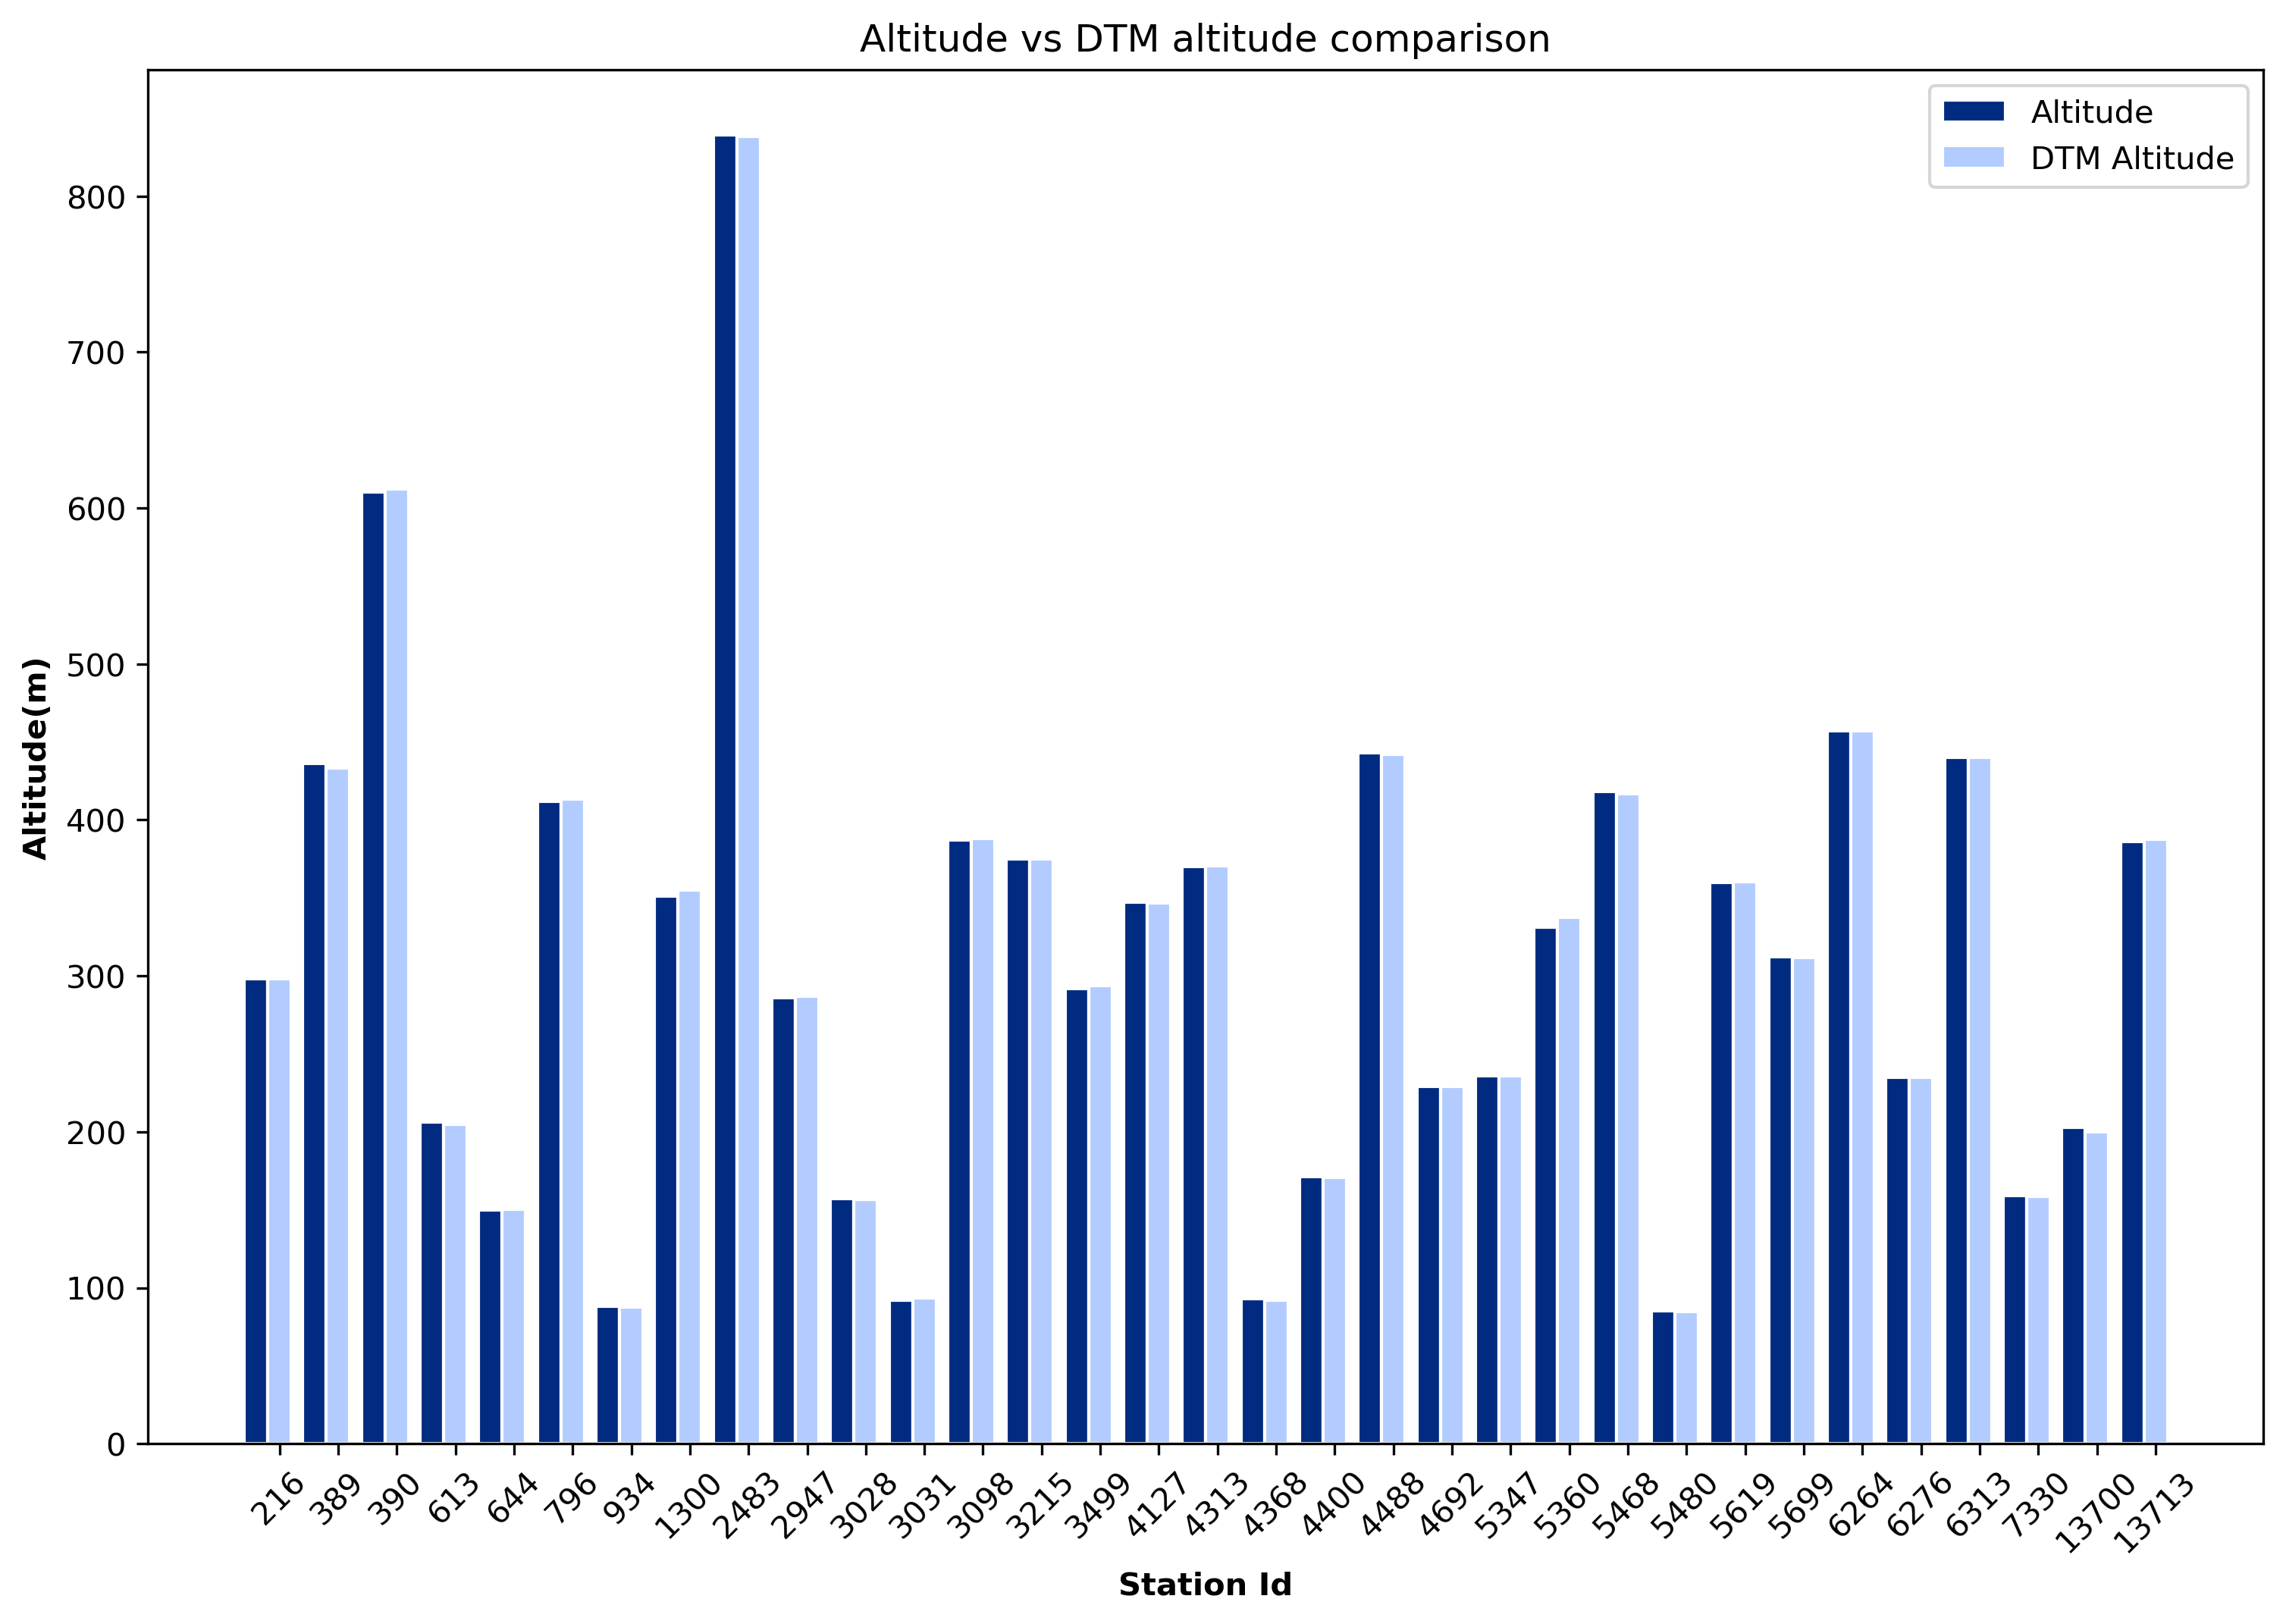

In [86]:
fig = plt.figure(dpi = 300, figsize = (12, 8), clear = True)
# set width of bars
bar_width = 0.40
r1 = np.arange(len(altitude))
r2 = [x + bar_width for x in r1]
 
# Make the plot
plt.bar(r1, altitude, color='#002b80', width=bar_width, edgecolor='white', label='Altitude')
plt.bar(r2, dtm_altitude, color='#b3ccff', width=bar_width, edgecolor='white', label='DTM Altitude')
 
# Add xticks on the middle of the group bars
plt.xlabel('Station Id', fontweight='bold')
plt.ylabel('Altitude(m)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(altitude))], labels, rotation= 45)
plt.title("Altitude vs DTM altitude comparison",)
 
# Create legend & Show graphic
plt.legend()
fig.savefig('altitude_vs_dtm_altitude.jpeg')
plt.show()